In [1]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings
import requests

In [2]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
# zeta parameters
zeta_fname = download_from_dropbox("https://www.dropbox.com/s/ax8sclh0r34oxrq/zeta_parameters.fits?dl=1")
zeta_params=Table.read(zeta_fname)
slope = zeta_params['slope'][0]
intercept=zeta_params['intercept'][0]

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevent

In [4]:
hubble_fname = download_from_dropbox("https://www.dropbox.com/s/bfoa17lz23976je/input_for_hubble_debiased_catalog.fits?dl=1")
votes_data=Table.read(hubble_fname)

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [5]:
subjects=set(votes_data['OBJNO'])

In [6]:
#Zeta-hat function for computing debiased values
z0 = 0.3 # we're correcting to redshift 0.3

def fhat_mel(f,z,z0,zeta_hat):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val
#assume zeta_hat is a linear function of surface brightness
def zeta_hat_lin(SB):
    
    val = 10.**((SB*slope) + intercept)
    return val

In [7]:
#And here we define our new table!
intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')
   #S24=24 character string 
    #c01 = Column(name='num_classifications', format='J', array=floatcolumn)          # c05 = c01, by definition

#format for Columns: D = double precision floating point, J = integer
c00 = Column(name='OBJNO', format='A24', array=strcolumn) 
c00t1 = Column(name='total_count',format='J',array=intcolumn)           #c00t1 = c01a1a, by definition
c00t2 = Column(name='total_weight',format='D',array=floatcolumn)

#reduced metadata: z, mu, Imaging
cz = Column(name='Z_BEST', format='D', array=floatcolumn)
cmu = Column(name='MU_HI', format='D', array=floatcolumn)
cim = Column(name='Imaging', format='A24', array=strcolumn) 


#Columns for Task 01 "Smooth or features"
c01cat = Column(name='Correctable_Category', format = 'A24', array=strcolumn)
c01a1a = Column(name='t01_smooth_or_features_a01_smooth_count', format='J', array=intcolumn)
c01a1b = Column(name='t01_smooth_or_features_a01_smooth_weight', format='D', array=floatcolumn)
c01a1c = Column(name='t01_smooth_or_features_a01_smooth_fraction', format='D', array=floatcolumn)
c01a1d = Column(name='t01_smooth_or_features_a01_smooth_weighted_fraction', format='D', array=floatcolumn)
c01a1e = Column(name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D', array=floatcolumn)
c01a1f = Column(name='t01_smooth_or_features_a01_smooth_lower_limit', format='D',array=floatcolumn)
c01a1g = Column(name='t01_smooth_or_features_a01_smooth_upper_limit', format='D',array=floatcolumn)
c01a1h = Column(name='t01_smooth_or_features_a01_smooth_best_fraction',format='D',array=floatcolumn)


c01a2a = Column(name='t01_smooth_or_features_a02_features_or_disk_count', format='J', array=intcolumn)
c01a2b = Column(name='t01_smooth_or_features_a02_features_or_disk_weight', format='D', array=floatcolumn)
c01a2c = Column(name='t01_smooth_or_features_a02_features_or_disk_fraction', format='D', array=floatcolumn)
c01a2d = Column(name='t01_smooth_or_features_a02_features_or_disk_weighted_fraction', format='D', array=floatcolumn)
c01a2e = Column(name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D', array=floatcolumn)
c01a2f = Column(name='t01_smooth_or_features_a02_features_or_disk_lower_limit', format='D',array=floatcolumn)
c01a2g = Column(name='t01_smooth_or_features_a02_features_or_disk_upper_limit', format='D',array=floatcolumn)
c01a2h = Column(name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D',array=floatcolumn)

c01a3a = Column(name='t01_smooth_or_features_a03_star_or_artifact_count', format='J', array=intcolumn)
c01a3b = Column(name='t01_smooth_or_features_a03_star_or_artifact_weight', format='D', array=floatcolumn)
c01a3c = Column(name='t01_smooth_or_features_a03_star_or_artifact_fraction', format='D', array=floatcolumn)
c01a3d = Column(name='t01_smooth_or_features_a03_star_or_artifact_weighted_fraction', format='D', array=floatcolumn)

c01t1 = Column(name='t01_smooth_or_features_total_count', format='J', array=intcolumn)
c01t2 = Column(name='t01_smooth_or_features_total_weight', format='D', array=floatcolumn)


#Columns for Task 02 "Edge on"
c02a1a = Column(name='t02_edgeon_a01_yes_count', format='J', array=intcolumn)
c02a1b = Column(name='t02_edgeon_a01_yes_weight', format='D', array=floatcolumn)
c02a1c = Column(name='t02_edgeon_a01_yes_fraction', format='D', array=floatcolumn)
c02a1d = Column(name='t02_edgeon_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c02a2a = Column(name='t02_edgeon_a02_no_count', format='J', array=intcolumn)
c02a2b = Column(name='t02_edgeon_a02_no_weight', format='D', array=floatcolumn)
c02a2c = Column(name='t02_edgeon_a02_no_fraction', format='D', array=floatcolumn)
c02a2d = Column(name='t02_edgeon_a02_no_weighted_fraction', format='D', array=floatcolumn)

c02t1 = Column(name='t02_edgeon_total_count', format='J', array=intcolumn)
c02t2 = Column(name='t02_edgeon_total_weight', format='D', array=floatcolumn)


#Columns for Task 03 "Bar"
c03a1a = Column(name='t03_bar_a01_bar_count', format='J', array=intcolumn)
c03a1b = Column(name='t03_bar_a01_bar_weight', format='D', array=floatcolumn)
c03a1c = Column(name='t03_bar_a01_bar_fraction', format='D', array=floatcolumn)
c03a1d = Column(name='t03_bar_a01_bar_weighted_fraction', format='D', array=floatcolumn)

c03a2a = Column(name='t03_bar_a02_no_bar_count', format='J', array=intcolumn)
c03a2b = Column(name='t03_bar_a02_no_bar_weight', format='D', array=floatcolumn)
c03a2c = Column(name='t03_bar_a02_no_bar_fraction', format='D', array=floatcolumn)
c03a2d = Column(name='t03_bar_a02_no_bar_weighted_fraction', format='D', array=floatcolumn)

c03t1 = Column(name='t03_bar_total_count', format='J', array=intcolumn)
c03t2 = Column(name='t03_bar_total_weight', format='D', array=floatcolumn)


#Columns for Task 04 "Spiral Arms"
c04a1a = Column(name='t04_spiral_a01_spiral_count', format='J', array=intcolumn)
c04a1b = Column(name='t04_spiral_a01_spiral_weight', format='D', array=floatcolumn)
c04a1c = Column(name='t04_spiral_a01_spiral_fraction', format='D', array=floatcolumn)
c04a1d = Column(name='t04_spiral_a01_spiral_weighted_fraction', format='D', array=floatcolumn)

c04a2a = Column(name='t04_spiral_a02_no_spiral_count', format='J', array=intcolumn)
c04a2b = Column(name='t04_spiral_a02_no_spiral_weight', format='D', array=floatcolumn)
c04a2c = Column(name='t04_spiral_a02_no_spiral_fraction', format='D', array=floatcolumn)
c04a2d = Column(name='t04_spiral_a02_no_spiral_weighted_fraction', format='D', array=floatcolumn)

c04t1 = Column(name='t04_spiral_total_count', format='J', array=intcolumn)
c04t2 = Column(name='t04_spiral_total_weight', format='D', array=floatcolumn)


#Columns for Task 05 "Bulge Prominence"
c05a1a = Column(name='t05_bulge_prominence_a01_no_bulge_count', format='J', array=intcolumn)
c05a1b = Column(name='t05_bulge_prominence_a01_no_bulge_weight', format='D', array=floatcolumn)
c05a1c = Column(name='t05_bulge_prominence_a01_no_bulge_fraction', format='D', array=floatcolumn)
c05a1d = Column(name='t05_bulge_prominence_a01_no_bulge_weighted_fraction', format='D', array=floatcolumn)

c05a2a = Column(name='t05_bulge_prominence_a02_just_noticeable_count', format='J', array=intcolumn)
c05a2b = Column(name='t05_bulge_prominence_a02_just_noticeable_weight', format='D', array=floatcolumn)
c05a2c = Column(name='t05_bulge_prominence_a02_just_noticeable_fraction', format='D', array=floatcolumn)
c05a2d = Column(name='t05_bulge_prominence_a02_just_noticeable_weighted_fraction', format='D', array=floatcolumn)

c05a3a = Column(name='t05_bulge_prominence_a03_obvious_count', format='J', array=intcolumn)
c05a3b = Column(name='t05_bulge_prominence_a03_obvious_weight', format='D', array=floatcolumn)
c05a3c = Column(name='t05_bulge_prominence_a03_obvious_fraction', format='D', array=floatcolumn)
c05a3d = Column(name='t05_bulge_prominence_a03_obvious_weighted_fraction', format='D', array=floatcolumn)

c05a4a = Column(name='t05_bulge_prominence_a04_dominant_count', format='J', array=intcolumn)
c05a4b = Column(name='t05_bulge_prominence_a04_dominant_weight', format='D', array=floatcolumn)
c05a4c = Column(name='t05_bulge_prominence_a04_dominant_fraction', format='D', array=floatcolumn)
c05a4d = Column(name='t05_bulge_prominence_a04_dominant_weighted_fraction', format='D', array=floatcolumn)

c05t1 = Column(name='t05_bulge_prominence_total_count', format='J', array=intcolumn)
c05t2 = Column(name='t05_bulge_prominence_total_weight', format='D', array=floatcolumn)


#Columns for Task 06 "Odd"
c06a1a = Column(name='t06_odd_a01_yes_count', format='J', array=intcolumn)
c06a1b = Column(name='t06_odd_a01_yes_weight', format='D', array=floatcolumn)
c06a1c = Column(name='t06_odd_a01_yes_fraction', format='D', array=floatcolumn)
c06a1d = Column(name='t06_odd_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c06a2a = Column(name='t06_odd_a02_no_count', format='J', array=intcolumn)
c06a2b = Column(name='t06_odd_a02_no_weight', format='D', array=floatcolumn)
c06a2c = Column(name='t06_odd_a02_no_fraction', format='D', array=floatcolumn)
c06a2d = Column(name='t06_odd_a02_no_weighted_fraction', format='D', array=floatcolumn)

c06t1 = Column(name='t06_odd_total_count', format='J', array=intcolumn)
c06t2 = Column(name='t06_odd_total_weight', format='D', array=floatcolumn)

#Columns for Task 07 "Rounded"
c07a1a = Column(name='t07_rounded_a01_completely_round_count', format='J', array=intcolumn)
c07a1b = Column(name='t07_rounded_a01_completely_round_weight', format='D', array=floatcolumn)
c07a1c = Column(name='t07_rounded_a01_completely_round_fraction', format='D', array=floatcolumn)
c07a1d = Column(name='t07_rounded_a01_completely_round_weighted_fraction', format='D', array=floatcolumn)

c07a2a = Column(name='t07_rounded_a02_in_between_count', format='J', array=intcolumn)
c07a2b = Column(name='t07_rounded_a02_in_between_weight', format='D', array=floatcolumn)
c07a2c = Column(name='t07_rounded_a02_in_between_fraction', format='D', array=floatcolumn)
c07a2d = Column(name='t07_rounded_a02_in_between_weighted_fraction', format='D', array=floatcolumn)

c07a3a = Column(name='t07_rounded_a03_cigar_shaped_count', format='J', array=intcolumn)
c07a3b = Column(name='t07_rounded_a03_cigar_shaped_weight', format='D', array=floatcolumn)
c07a3c = Column(name='t07_rounded_a03_cigar_shaped_fraction', format='D', array=floatcolumn)
c07a3d = Column(name='t07_rounded_a03_cigar_shaped_weighted_fraction', format='D', array=floatcolumn)

c07t1 = Column(name='t07_rounded_total_count', format='J', array=intcolumn)
c07t2 = Column(name='t07_rounded_total_weight', format='D', array=floatcolumn)

#Columns for Task 08 "Odd Feature"
c08a1a = Column(name='t08_odd_feature_a01_ring_count', format='J', array=intcolumn)
c08a1b = Column(name='t08_odd_feature_a01_ring_weight', format='D', array=floatcolumn)
c08a1c = Column(name='t08_odd_feature_a01_ring_fraction', format='D', array=floatcolumn)
c08a1d = Column(name='t08_odd_feature_a01_ring_weighted_fraction', format='D', array=floatcolumn)

c08a2a = Column(name='t08_odd_feature_a02_lens_or_arc_count', format='J', array=intcolumn)
c08a2b = Column(name='t08_odd_feature_a02_lens_or_arc_weight', format='D', array=floatcolumn)
c08a2c = Column(name='t08_odd_feature_a02_lens_or_arc_fraction', format='D', array=floatcolumn)
c08a2d = Column(name='t08_odd_feature_a02_lens_or_arc_weighted_fraction', format='D', array=floatcolumn)

c08a3a = Column(name='t08_odd_feature_a03_disturbed_count', format='J', array=intcolumn)
c08a3b = Column(name='t08_odd_feature_a03_disturbed_weight', format='D', array=floatcolumn)
c08a3c = Column(name='t08_odd_feature_a03_disturbed_fraction', format='D', array=floatcolumn)
c08a3d = Column(name='t08_odd_feature_a03_disturbed_weighted_fraction', format='D', array=floatcolumn)

c08a4a = Column(name='t08_odd_feature_a04_irregular_count', format='J', array=intcolumn)
c08a4b = Column(name='t08_odd_feature_a04_irregular_weight', format='D', array=floatcolumn)
c08a4c = Column(name='t08_odd_feature_a04_irregular_fraction', format='D', array=floatcolumn)
c08a4d = Column(name='t08_odd_feature_a04_irregular_weighted_fraction', format='D', array=floatcolumn)

c08a5a = Column(name='t08_odd_feature_a05_other_count', format='J', array=intcolumn)
c08a5b = Column(name='t08_odd_feature_a05_other_weight', format='D', array=floatcolumn)
c08a5c = Column(name='t08_odd_feature_a05_other_fraction', format='D', array=floatcolumn)
c08a5d = Column(name='t08_odd_feature_a05_other_weighted_fraction', format='D', array=floatcolumn)

c08a6a = Column(name='t08_odd_feature_a06_merger_count', format='J', array=intcolumn)
c08a6b = Column(name='t08_odd_feature_a06_merger_weight', format='D', array=floatcolumn)
c08a6c = Column(name='t08_odd_feature_a06_merger_fraction', format='D', array=floatcolumn)
c08a6d = Column(name='t08_odd_feature_a06_merger_weighted_fraction', format='D', array=floatcolumn)

c08a7a = Column(name='t08_odd_feature_a07_dust_lane_count', format='J', array=intcolumn)
c08a7b = Column(name='t08_odd_feature_a07_dust_lane_weight', format='D', array=floatcolumn)
c08a7c = Column(name='t08_odd_feature_a07_dust_lane_fraction', format='D', array=floatcolumn)
c08a7d = Column(name='t08_odd_feature_a07_dust_lane_weighted_fraction', format='D', array=floatcolumn)

c08t1 = Column(name='t08_odd_feature_total_count', format='J', array=intcolumn)
c08t2 = Column(name='t08_odd_feature_total_weight', format='D', array=floatcolumn)

#Columns for Task 09 "Bulge Shape"
c09a1a = Column(name='t09_bulge_shape_a01_rounded_count', format='J', array=intcolumn)
c09a1b = Column(name='t09_bulge_shape_a01_rounded_weight', format='D', array=floatcolumn)
c09a1c = Column(name='t09_bulge_shape_a01_rounded_fraction', format='D', array=floatcolumn)
c09a1d = Column(name='t09_bulge_shape_a01_rounded_weighted_fraction', format='D', array=floatcolumn)

c09a2a = Column(name='t09_bulge_shape_a02_boxy_count', format='J', array=intcolumn)
c09a2b = Column(name='t09_bulge_shape_a02_boxy_weight', format='D', array=floatcolumn)
c09a2c = Column(name='t09_bulge_shape_a02_boxy_fraction', format='D', array=floatcolumn)
c09a2d = Column(name='t09_bulge_shape_a02_boxy_weighted_fraction', format='D', array=floatcolumn)

c09a3a = Column(name='t09_bulge_shape_a03_no_bulge_count', format='J', array=intcolumn)
c09a3b = Column(name='t09_bulge_shape_a03_no_bulge_weight', format='D', array=floatcolumn)
c09a3c = Column(name='t09_bulge_shape_a03_no_bulge_fraction', format='D', array=floatcolumn)
c09a3d = Column(name='t09_bulge_shape_a03_no_bulge_weighted_fraction', format='D', array=floatcolumn)

c09t1 = Column(name='t09_bulge_shape_total_count', format='J', array=intcolumn)
c09t2 = Column(name='t09_bulge_shape_total_weight', format='D', array=floatcolumn)

#Columns for Task 10 "Arms Winding"
c10a1a = Column(name='t10_arms_winding_a01_tight_count', format='J', array=intcolumn)
c10a1b = Column(name='t10_arms_winding_a01_tight_weight', format='D', array=floatcolumn)
c10a1c = Column(name='t10_arms_winding_a01_tight_fraction', format='D', array=floatcolumn)
c10a1d = Column(name='t10_arms_winding_a01_tight_weighted_fraction', format='D', array=floatcolumn)

c10a2a = Column(name='t10_arms_winding_a02_medium_count', format='J', array=intcolumn)
c10a2b = Column(name='t10_arms_winding_a02_medium_weight', format='D', array=floatcolumn)
c10a2c = Column(name='t10_arms_winding_a02_medium_fraction', format='D', array=floatcolumn)
c10a2d = Column(name='t10_arms_winding_a02_medium_weighted_fraction', format='D', array=floatcolumn)

c10a3a = Column(name='t10_arms_winding_a03_loose_count', format='J', array=intcolumn)
c10a3b = Column(name='t10_arms_winding_a03_loose_weight', format='D', array=floatcolumn)
c10a3c = Column(name='t10_arms_winding_a03_loose_fraction', format='D', array=floatcolumn)
c10a3d = Column(name='t10_arms_winding_a03_loose_weighted_fraction', format='D', array=floatcolumn)

c10t1 = Column(name='t10_arms_winding_total_count', format='J', array=intcolumn)
c10t2 = Column(name='t10_arms_winding_total_weight', format='D', array=floatcolumn)

#Columns for Task 11 "Arms Number"
c11a1a = Column(name='t11_arms_number_a01_1_count', format='J', array=intcolumn)
c11a1b = Column(name='t11_arms_number_a01_1_weight', format='D', array=floatcolumn)
c11a1c = Column(name='t11_arms_number_a01_1_fraction', format='D', array=floatcolumn)
c11a1d = Column(name='t11_arms_number_a01_1_weighted_fraction', format='D', array=floatcolumn)

c11a2a = Column(name='t11_arms_number_a02_2_count', format='J', array=intcolumn)
c11a2b = Column(name='t11_arms_number_a02_2_weight', format='D', array=floatcolumn)
c11a2c = Column(name='t11_arms_number_a02_2_fraction', format='D', array=floatcolumn)
c11a2d = Column(name='t11_arms_number_a02_2_weighted_fraction', format='D', array=floatcolumn)

c11a3a = Column(name='t11_arms_number_a03_3_count', format='J', array=intcolumn)
c11a3b = Column(name='t11_arms_number_a03_3_weight', format='D', array=floatcolumn)
c11a3c = Column(name='t11_arms_number_a03_3_fraction', format='D', array=floatcolumn)
c11a3d = Column(name='t11_arms_number_a03_3_weighted_fraction', format='D', array=floatcolumn)

c11a4a = Column(name='t11_arms_number_a04_4_count', format='J', array=intcolumn)
c11a4b = Column(name='t11_arms_number_a04_4_weight', format='D', array=floatcolumn)
c11a4c = Column(name='t11_arms_number_a04_4_fraction', format='D', array=floatcolumn)
c11a4d = Column(name='t11_arms_number_a04_4_weighted_fraction', format='D', array=floatcolumn)

c11a5a = Column(name='t11_arms_number_a05_more_than_4_count', format='J', array=intcolumn)
c11a5b = Column(name='t11_arms_number_a05_more_than_4_weight', format='D', array=floatcolumn)
c11a5c = Column(name='t11_arms_number_a05_more_than_4_fraction', format='D', array=floatcolumn)
c11a5d = Column(name='t11_arms_number_a05_more_than_4_weighted_fraction', format='D', array=floatcolumn)

c11a6a = Column(name='t11_arms_number_a06_cant_tell_count', format='J', array=intcolumn)
c11a6b = Column(name='t11_arms_number_a06_cant_tell_weight', format='D', array=floatcolumn)
c11a6c = Column(name='t11_arms_number_a06_cant_tell_fraction', format='D', array=floatcolumn)
c11a6d = Column(name='t11_arms_number_a06_cant_tell_weighted_fraction', format='D', array=floatcolumn)

c11t1 = Column(name='t11_arms_number_total_count', format='J', array=intcolumn)
c11t2 = Column(name='t11_arms_number_total_weight', format='D', array=floatcolumn)

#Columns for Task 12 "Clumpy"
c12a1a = Column(name='t12_clumpy_a01_yes_count', format='J', array=intcolumn)
c12a1b = Column(name='t12_clumpy_a01_yes_weight', format='D', array=floatcolumn)
c12a1c = Column(name='t12_clumpy_a01_yes_fraction', format='D', array=floatcolumn)
c12a1d = Column(name='t12_clumpy_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c12a2a = Column(name='t12_clumpy_a02_no_count', format='J', array=intcolumn)
c12a2b = Column(name='t12_clumpy_a02_no_weight', format='D', array=floatcolumn)
c12a2c = Column(name='t12_clumpy_a02_no_fraction', format='D', array=floatcolumn)
c12a2d = Column(name='t12_clumpy_a02_no_weighted_fraction', format='D', array=floatcolumn)

c12t1 = Column(name='t12_clumpy_total_count', format='J', array=intcolumn)
c12t2 = Column(name='t12_clumpy_total_weight', format='D', array=floatcolumn)

#Columns for Task 13 "Multiple Clumps"
c13a1a = Column(name='t13_multiple_clumps_a01_yes_count', format='J', array=intcolumn)
c13a1b = Column(name='t13_multiple_clumps_a01_yes_weight', format='D', array=floatcolumn)
c13a1c = Column(name='t13_multiple_clumps_a01_yes_fraction', format='D', array=floatcolumn)
c13a1d = Column(name='t13_multiple_clumps_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c13a2a = Column(name='t13_multiple_clumps_a02_no_count', format='J', array=intcolumn)
c13a2b = Column(name='t13_multiple_clumps_a02_no_weight', format='D', array=floatcolumn)
c13a2c = Column(name='t13_multiple_clumps_a02_no_fraction', format='D', array=floatcolumn)
c13a2d = Column(name='t13_multiple_clumps_a02_no_weighted_fraction', format='D', array=floatcolumn)

c13t1 = Column(name='t13_multiple_clumps_total_count', format='J', array=intcolumn)
c13t2 = Column(name='t13_multiple_clumps_total_weight', format='D', array=floatcolumn)


#Columns for Task 14 "Bright Clump"
c14a1a = Column(name='t14_bright_clump_a01_yes_count', format='J', array=intcolumn)
c14a1b = Column(name='t14_bright_clump_a01_yes_weight', format='D', array=floatcolumn)
c14a1c = Column(name='t14_bright_clump_a01_yes_fraction', format='D', array=floatcolumn)
c14a1d = Column(name='t14_bright_clump_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c14a2a = Column(name='t14_bright_clump_a02_no_count', format='J', array=intcolumn)
c14a2b = Column(name='t14_bright_clump_a02_no_weight', format='D', array=floatcolumn)
c14a2c = Column(name='t14_bright_clump_a02_no_fraction', format='D', array=floatcolumn)
c14a2d = Column(name='t14_bright_clump_a02_no_weighted_fraction', format='D', array=floatcolumn)

c14t1 = Column(name='t14_bright_clump_total_count', format='J', array=intcolumn)
c14t2 = Column(name='t14_bright_clump_total_weight', format='D', array=floatcolumn)


#Columns for Task 15 "Bright Clump Central"
c15a1a = Column(name='t15_bright_clump_central_a01_yes_count', format='J', array=intcolumn)
c15a1b = Column(name='t15_bright_clump_central_a01_yes_weight', format='D', array=floatcolumn)
c15a1c = Column(name='t15_bright_clump_central_a01_yes_fraction', format='D', array=floatcolumn)
c15a1d = Column(name='t15_bright_clump_central_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c15a2a = Column(name='t15_bright_clump_central_a02_no_count', format='J', array=intcolumn)
c15a2b = Column(name='t15_bright_clump_central_a02_no_weight', format='D', array=floatcolumn)
c15a2c = Column(name='t15_bright_clump_central_a02_no_fraction', format='D', array=floatcolumn)
c15a2d = Column(name='t15_bright_clump_central_a02_no_weighted_fraction', format='D', array=floatcolumn)

c15t1 = Column(name='t15_bright_clump_central_total_count', format='J', array=intcolumn)
c15t2 = Column(name='t15_bright_clump_central_total_weight', format='D', array=floatcolumn)

#Columns for Task 16 "Clumps Arrangement"
c16a1a = Column(name='t16_clumps_arrangement_a01_line_count', format='J', array=intcolumn)
c16a1b = Column(name='t16_clumps_arrangement_a01_line_weight', format='D', array=floatcolumn)
c16a1c = Column(name='t16_clumps_arrangement_a01_line_fraction', format='D', array=floatcolumn)
c16a1d = Column(name='t16_clumps_arrangement_a01_line_weighted_fraction', format='D', array=floatcolumn)

c16a2a = Column(name='t16_clumps_arrangement_a02_chain_count', format='J', array=intcolumn)
c16a2b = Column(name='t16_clumps_arrangement_a02_chain_weight', format='D', array=floatcolumn)
c16a2c = Column(name='t16_clumps_arrangement_a02_chain_fraction', format='D', array=floatcolumn)
c16a2d = Column(name='t16_clumps_arrangement_a02_chain_weighted_fraction', format='D', array=floatcolumn)

c16a3a = Column(name='t16_clumps_arrangement_a03_cluster_count', format='J', array=intcolumn)
c16a3b = Column(name='t16_clumps_arrangement_a03_cluster_weight', format='D', array=floatcolumn)
c16a3c = Column(name='t16_clumps_arrangement_a03_cluster_fraction', format='D', array=floatcolumn)
c16a3d = Column(name='t16_clumps_arrangement_a03_cluster_weighted_fraction', format='D', array=floatcolumn)

c16a4a = Column(name='t16_clumps_arrangement_a04_spiral_count', format='J', array=intcolumn)
c16a4b = Column(name='t16_clumps_arrangement_a04_spiral_weight', format='D', array=floatcolumn)
c16a4c = Column(name='t16_clumps_arrangement_a04_spiral_fraction', format='D', array=floatcolumn)
c16a4d = Column(name='t16_clumps_arrangement_a04_spiral_weighted_fraction', format='D', array=floatcolumn)

c16t1 = Column(name='t16_clumps_arrangement_total_count', format='J', array=intcolumn)
c16t2 = Column(name='t16_clumps_arrangement_total_weight', format='D', array=floatcolumn)

#Columns for Task 17 "Clumps Number"
c17a1a = Column(name='t17_clumps_count_a01_1_count', format='J', array=intcolumn)
c17a1b = Column(name='t17_clumps_count_a01_1_weight', format='D', array=floatcolumn)
c17a1c = Column(name='t17_clumps_count_a01_1_fraction', format='D', array=floatcolumn)
c17a1d = Column(name='t17_clumps_count_a01_1_weighted_fraction', format='D', array=floatcolumn)

c17a2a = Column(name='t17_clumps_count_a02_2_count', format='J', array=intcolumn)
c17a2b = Column(name='t17_clumps_count_a02_2_weight', format='D', array=floatcolumn)
c17a2c = Column(name='t17_clumps_count_a02_2_fraction', format='D', array=floatcolumn)
c17a2d = Column(name='t17_clumps_count_a02_2_weighted_fraction', format='D', array=floatcolumn)

c17a3a = Column(name='t17_clumps_count_a03_3_count', format='J', array=intcolumn)
c17a3b = Column(name='t17_clumps_count_a03_3_weight', format='D', array=floatcolumn)
c17a3c = Column(name='t17_clumps_count_a03_3_fraction', format='D', array=floatcolumn)
c17a3d = Column(name='t17_clumps_count_a03_3_weighted_fraction', format='D', array=floatcolumn)

c17a4a = Column(name='t17_clumps_count_a04_4_count', format='J', array=intcolumn)
c17a4b = Column(name='t17_clumps_count_a04_4_weight', format='D', array=floatcolumn)
c17a4c = Column(name='t17_clumps_count_a04_4_fraction', format='D', array=floatcolumn)
c17a4d = Column(name='t17_clumps_count_a04_4_weighted_fraction', format='D', array=floatcolumn)

c17a5a = Column(name='t17_clumps_count_a05_more_than_4_count', format='J', array=intcolumn)
c17a5b = Column(name='t17_clumps_count_a05_more_than_4_weight', format='D', array=floatcolumn)
c17a5c = Column(name='t17_clumps_count_a05_more_than_4_fraction', format='D', array=floatcolumn)
c17a5d = Column(name='t17_clumps_count_a05_more_than_4_weighted_fraction', format='D', array=floatcolumn)

c17a6a = Column(name='t17_clumps_count_a06_cant_tell_count', format='J', array=intcolumn)
c17a6b = Column(name='t17_clumps_count_a06_cant_tell_weight', format='D', array=floatcolumn)
c17a6c = Column(name='t17_clumps_count_a06_cant_tell_fraction', format='D', array=floatcolumn)
c17a6d = Column(name='t17_clumps_count_a06_cant_tell_weighted_fraction', format='D', array=floatcolumn)

c17t1 = Column(name='t17_clumps_count_total_count', format='J', array=intcolumn)
c17t2 = Column(name='t17_clumps_count_total_weight', format='D', array=floatcolumn)

#Columns for Task 18 "Clumps Symmetrical"
c18a1a = Column(name='t18_clumps_symmetrical_a01_yes_count', format='J', array=intcolumn)
c18a1b = Column(name='t18_clumps_symmetrical_a01_yes_weight', format='D', array=floatcolumn)
c18a1c = Column(name='t18_clumps_symmetrical_a01_yes_fraction', format='D', array=floatcolumn)
c18a1d = Column(name='t18_clumps_symmetrical_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c18a2a = Column(name='t18_clumps_symmetrical_a02_no_count', format='J', array=intcolumn)
c18a2b = Column(name='t18_clumps_symmetrical_a02_no_weight', format='D', array=floatcolumn)
c18a2c = Column(name='t18_clumps_symmetrical_a02_no_fraction', format='D', array=floatcolumn)
c18a2d = Column(name='t18_clumps_symmetrical_a02_no_weighted_fraction', format='D', array=floatcolumn)

c18t1 = Column(name='t18_clumps_symmetrical_total_count', format='J', array=intcolumn)
c18t2 = Column(name='t18_clumps_symmetrical_total_weight', format='D', array=floatcolumn)

#Columns for Task 19 "Clumps Embedded"
c19a1a = Column(name='t19_clumps_embedded_a01_yes_count', format='J', array=intcolumn)
c19a1b = Column(name='t19_clumps_embedded_a01_yes_weight', format='D', array=floatcolumn)
c19a1c = Column(name='t19_clumps_embedded_a01_yes_fraction', format='D', array=floatcolumn)
c19a1d = Column(name='t19_clumps_embedded_a01_yes_weighted_fraction', format='D', array=floatcolumn)

c19a2a = Column(name='t19_clumps_embedded_a02_no_count', format='J', array=intcolumn)
c19a2b = Column(name='t19_clumps_embedded_a02_no_weight', format='D', array=floatcolumn)
c19a2c = Column(name='t19_clumps_embedded_a02_no_fraction', format='D', array=floatcolumn)
c19a2d = Column(name='t19_clumps_embedded_a02_no_weighted_fraction', format='D', array=floatcolumn)

c19t1 = Column(name='t19_clumps_embedded_total_count', format='J', array=intcolumn)
c19t2 = Column(name='t19_clumps_embedded_total_weight', format='D', array=floatcolumn)

In [8]:
classifications = pyfits.new_table([c00,c00t1,c00t2,
                                    cz, cmu, cim,
                                    c01cat,
                                    c01a1a,c01a1b,c01a1c,c01a1d,c01a1e,c01a1f,c01a1g,c01a1h,
                                    c01a2a,c01a2b,c01a2c,c01a2d,c01a2e,c01a2f,c01a2g,c01a2h,
                                    c01a3a,c01a3b,c01a3c,c01a3d,
                                    c01t1,c01t2,
                                    c02a1a,c02a1b,c02a1c,c02a1d,
                                    c02a2a,c02a2b,c02a2c,c02a2d,
                                    c02t1,c02t2,
                                    c03a1a,c03a1b,c03a1c,c03a1d,
                                    c03a2a,c03a2b,c03a2c,c03a2d,
                                    c03t1,c03t2,
                                    c04a1a,c04a1b,c04a1c,c04a1d,
                                    c04a2a,c04a2b,c04a2c,c04a2d,
                                    c04t1,c04t2,
                                    c05a1a,c05a1b,c05a1c,c05a1d,
                                    c05a2a,c05a2b,c05a2c,c05a2d,
                                    c05a3a,c05a3b,c05a3c,c05a3d,
                                    c05a4a,c05a4b,c05a4c,c05a4d,
                                    c05t1,c05t2,  
                                    c06a1a,c06a1b,c06a1c,c06a1d,
                                    c06a2a,c06a2b,c06a2c,c06a2d,
                                    c06t1,c06t2,
                                    c07a1a,c07a1b,c07a1c,c07a1d,
                                    c07a2a,c07a2b,c07a2c,c07a2d,
                                    c07a3a,c07a3b,c07a3c,c07a3d,
                                    c07t1,c07t2,
                                    c08a1a,c08a1b,c08a1c,c08a1d,
                                    c08a2a,c08a2b,c08a2c,c08a2d,
                                    c08a3a,c08a3b,c08a3c,c08a3d,
                                    c08a4a,c08a4b,c08a4c,c08a4d,
                                    c08a5a,c08a5b,c08a5c,c08a5d,
                                    c08a6a,c08a6b,c08a6c,c08a6d,
                                    c08a7a,c08a7b,c08a7c,c08a7d,
                                    c08t1,c08t2,
                                    c09a1a,c09a1b,c09a1c,c09a1d,
                                    c09a2a,c09a2b,c09a2c,c09a2d,
                                    c09a3a,c09a3b,c09a3c,c09a3d,
                                    c09t1,c09t2,
                                    c10a1a,c10a1b,c10a1c,c10a1d,
                                    c10a2a,c10a2b,c10a2c,c10a2d,
                                    c10a3a,c10a3b,c10a3c,c10a3d,
                                    c10t1,c10t2,
                                    c11a1a,c11a1b,c11a1c,c11a1d,
                                    c11a2a,c11a2b,c11a2c,c11a2d,
                                    c11a3a,c11a3b,c11a3c,c11a3d,
                                    c11a4a,c11a4b,c11a4c,c11a4d,
                                    c11a5a,c11a5b,c11a5c,c11a5d,
                                    c11a6a,c11a6b,c11a6c,c11a6d,
                                    c11t1,c11t2,
                                    c12a1a,c12a1b,c12a1c,c12a1d,
                                    c12a2a,c12a2b,c12a2c,c12a2d,
                                    c12t1,c12t2,
                                    c13a1a,c13a1b,c13a1c,c13a1d,
                                    c13a2a,c13a2b,c13a2c,c13a2d,
                                    c13t1,c13t2,
                                    c14a1a,c14a1b,c14a1c,c14a1d,
                                    c14a2a,c14a2b,c14a2c,c14a2d,
                                    c14t1,c14t2,
                                    c15a1a,c15a1b,c15a1c,c15a1d,
                                    c15a2a,c15a2b,c15a2c,c15a2d,
                                    c15t1,c15t2,
                                    c16a1a,c16a1b,c16a1c,c16a1d,
                                    c16a2a,c16a2b,c16a2c,c16a2d,
                                    c16a3a,c16a3b,c16a3c,c16a3d,
                                    c16a4a,c16a4b,c16a4c,c16a4d,
                                    c16t1,c16t2,
                                    c17a1a,c17a1b,c17a1c,c17a1d,
                                    c17a2a,c17a2b,c17a2c,c17a2d,
                                    c17a3a,c17a3b,c17a3c,c17a3d,
                                    c17a4a,c17a4b,c17a4c,c17a4d,
                                    c17a5a,c17a5b,c17a5c,c17a5d,
                                    c17a6a,c17a6b,c17a6c,c17a6d,
                                    c17t1,c17t2,
                                    c18a1a,c18a1b,c18a1c,c18a1d,
                                    c18a2a,c18a2b,c18a2c,c18a2d,
                                    c18t1,c18t2,
                                    c19a1a,c19a1b,c19a1c,c19a1d,
                                    c19a2a,c19a2b,c19a2c,c19a2d,
                                    c19t1,c19t2
                                     ])
                                    
hubble_catalog = pyfits.new_table(classifications.columns)                         

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [9]:
#First copy the raw and weighted vote information to new table. 
#remove columns that are not in old table - those will be transferred manually 
old_columns = classifications.columns.names
old_columns.remove('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')
old_columns.remove('t01_smooth_or_features_a02_features_or_disk_best_fraction')
old_columns.remove('t01_smooth_or_features_a01_smooth_debiased_fraction')
old_columns.remove('t01_smooth_or_features_a01_smooth_lower_limit')
old_columns.remove('t01_smooth_or_features_a01_smooth_upper_limit')
old_columns.remove('t01_smooth_or_features_a01_smooth_best_fraction')

In [10]:
z = 'Z_BEST'
print 'Writing file...'
for i,gal in enumerate(votes_data):
    if i % 1000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
    #transfer all raw/weighted data
    for column_name in old_columns:
        hubble_catalog.data.field(column_name)[i] = gal[column_name]
        
        
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal['MU_HI']))
    hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if hubble_catalog.data.field('Correctable_Category')[i]=='correctable':
        p_features_best = hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif hubble_catalog.data.field('Correctable_Category')[i]=='uncorrectable':
        p_features_best = max(hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i])
    else:
        p_features_best = hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    hubble_catalog.data.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    hubble_catalog.data.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    hubble_catalog.data.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    hubble_catalog.data.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    hubble_catalog.data.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

    

Writing file...
Writing 0th row at time 14:05:41.342655
Writing 1000th row at time 14:07:31.465572
Writing 2000th row at time 14:09:18.005438
Writing 3000th row at time 14:11:05.093490

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars



Writing 4000th row at time 14:12:54.482881
Writing 5000th row at time 14:14:39.829646
Writing 6000th row at time 14:16:27.777981
Writing 7000th row at time 14:18:15.658769
Writing 8000th row at time 14:20:01.060678
Writing 9000th row at time 14:21:46.613539
Writing 10000th row at time 14:23:34.692511
Writing 11000th row at time 14:25:22.241569
Writing 12000th row at time 14:27:07.054393
Writing 13000th row at time 14:28:52.769150
Writing 14000th row at time 14:30:34.577037
Writing 15000th row at time 14:32:18.588607
Writing 16000th row at time 14:34:01.639232
Writing 17000th row at time 14:35:43.978670
Writing 18000th row at time 14:37:30.287328
Writing 19000th row at time 14:39:13.742739
Writing 20000th row at time 14:40:57.003118
Writing 21000th row at time 14:42:41.500394
Writing 22000th row at time 14:44:25.138887
Writing 23000th row at time 14:46:08.557537
Writing 24000th row at time 14:47:51.346615
Writing 25000th row at time 14:49:34.080300
Writing 26000th row at time 14:51:16.

In [11]:
from datetime import datetime
#write to file 
hubble_catalog.writeto('/home/mel/Dropbox/gzhubble/hubble_files/gz_hubble_catalog_%i_%i_%i.fits'%(datetime.now().month,datetime.now().day,datetime.now().year),clobber=True)

In [18]:
correctable=(votes_data['Correctable_Category']=='correctable        ')
uncorrectable=(votes_data['Correctable_Category']=='uncorrectable      ')
nei=(votes_data['Correctable_Category']=='nei                ')

old_votes=votes_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
old_lower_limit=votes_data['t01_smooth_or_features_a02_features_or_disk_lower_limit']
old_z=votes_data[z]
old_mu=votes_data['MU_HI']

new_c=fhat_mel(old_votes[correctable],old_z[correctable],z0,zeta_hat_lin(old_mu[correctable]))
new_unc=fhat_mel(old_votes[uncorrectable],old_z[uncorrectable],z0,zeta_hat_lin(old_mu[uncorrectable])) #debiased value
#new_unc = old_lower_limit[uncorrectable] #lower limit
new_nei=fhat_mel(old_votes[nei],old_z[nei],z0,zeta_hat_lin(old_mu[nei]))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


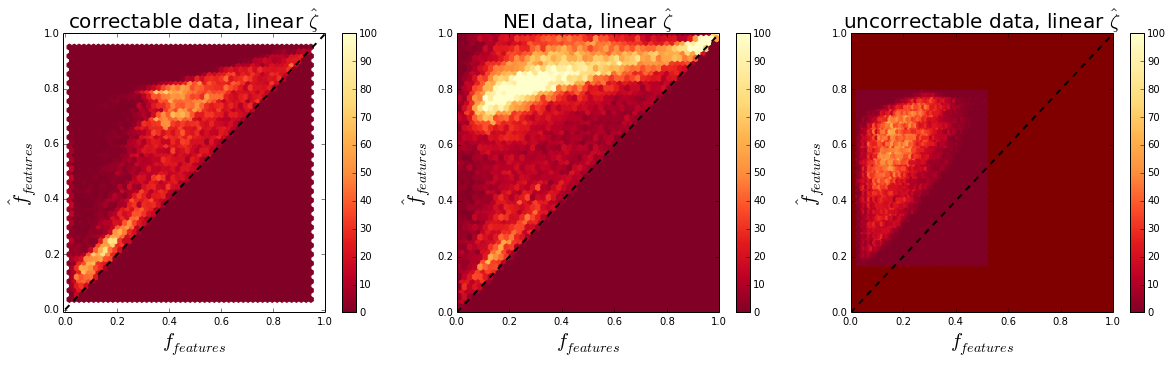

In [19]:
# 2D histogram of new p_features distribution
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
hex1 = ax1.hexbin(old_votes[correctable],new_c, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('correctable data, linear $\hat \zeta$',fontsize=20)

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Try it with Mel's new function
ax2 = fig.add_subplot(132)
hex2 = ax2.hexbin(old_votes[nei],new_nei, cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('NEI data, linear $\hat \zeta$',fontsize=20)

ax3 = fig.add_subplot(133)
hex3 = ax3.hexbin(old_votes[uncorrectable],new_unc, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0, vmax=100)
ax3.set_xlabel(r'$f_{features}$',fontsize=20)
ax3.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
cb3 = plt.colorbar(hex3)
ax3.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax3.set_title('uncorrectable data, linear $\hat \zeta$',fontsize=20)
ax3.set_axis_bgcolor('#800000')

